<a href="https://colab.research.google.com/github/AshAswin/evidential_mcdo_adf_gp/blob/main/GP_Regression_toydataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
!pip install gpflow
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
from gpflow.utilities import print_summary
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
import gpflow as gpf
np.random.seed(0)
tf.random.set_seed(0)
from abc import ABC, abstractmethod
from dataclasses import dataclass

In [ ]:
mu = 0
sigma = 0.08
train_range = np.linspace(-3, 3, 100).reshape(-1,1)
test_range = np.linspace(-5,5,100).reshape(-1,1)
function = lambda x:np.sin(3*x)/(3*x)

In [ ]:
class Data():
  def __init__(self, x, func, noise={'mu':0,'sigma':1}):
    self.x = x
    self.y_gt = func(self.x)
    self.epsilon = np.random.normal(noise['mu'],noise['sigma'],np.shape(x))
    self.y = self.y_gt + self.epsilon

def plot_results(train_data,test_data, prediction, aleatoric, epistemic,\
                 limits,fn_samples,title=''):
  #Obtain Standard Deviation  
  aleatoric = np.sqrt(aleatoric)
  epistemic = np.sqrt(epistemic)
  # plot and show learning process
  fig, ax = plt.subplots(figsize=(15,10))
  plt.cla()

  aleatoric = aleatoric[:,0]
  epistemic = epistemic[:,0]#.squeeze()
  prediction = prediction[:,0]
  ax.fill_between(test_data.x.squeeze(), prediction + 2*aleatoric, prediction - 2*aleatoric, color='green',alpha=0.3,label='aleatoric')
  ax.fill_between(test_data.x.squeeze(), prediction +2*epistemic, prediction-2*epistemic, color='yellow',alpha=0.5,label='epistemic')

  ax.set_title(title, fontsize=35)
  ax.set_xlabel('Input', fontsize=24)
  ax.set_ylabel('Prediction', fontsize=24)
  ax.set_xlim(limits['x'])
  ax.set_ylim(limits['y'])
  #ax.axvspan(x_lim[0], -3, alpha=0.1, color='blue')
  #ax.axvspan(3, x_lim[1], alpha=0.1, color='blue')
  ax.scatter(train_data.x.squeeze(), train_data.y.squeeze(), color = "black",marker='x', label='train_inputs')
  ax.plot(test_data.x.squeeze(), prediction, 'g-', lw=3, label='prediction',color='cyan')
  ax.plot(test_data.x.squeeze(),test_data.y_gt.squeeze(),lw=3,alpha = 0.7,label='ground truth',color='orange',linestyle='--')
  plt.legend()

In [ ]:
train_data = Data(train_range, function,noise={'mu':mu, 'sigma':sigma})
test_data = Data(test_range, function,noise={'mu':mu, 'sigma':sigma})

In [ ]:
#Homoscedastic GP params initialization
homo_kernel = gpflow.kernels.Matern52()

homo_gp_mdl = gpflow.models.GPR(data=(train_data.x,train_data.y), kernel=homo_kernel, mean_function=None)
homo_gp_mdl.likelihood.variance.assign(0.01)
homo_gp_mdl.kernel.lengthscales.assign(0.3)

homo_opt = gpflow.optimizers.Scipy()
opt_logs = homo_opt.minimize(homo_gp_mdl.training_loss, homo_gp_mdl.trainable_variables, options=dict(maxiter=100))

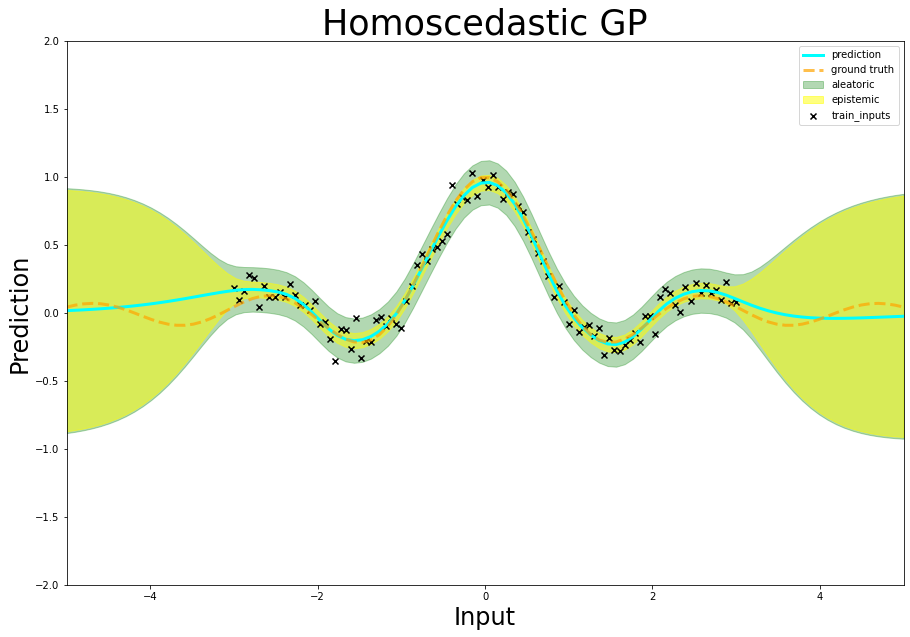

In [ ]:
#Homoscedastic GP inference
mean, epistemic= homo_gp_mdl.predict_f(test_data.x)
_ , aleatoric = homo_gp_mdl.predict_y(test_data.x)
function_samples = homo_gp_mdl.predict_f_samples(test_data.x,10)
#plot outputs
#plot_results(test_data.x, test_data.y, test_data.y_gt, mean, aleatoric, epistemic,function_samples,title='Homoscedastic GP')
plot_results(train_data,test_data, mean, aleatoric, epistemic,limits={"x":(-5,5),"y":(-2,2)},fn_samples=function_samples,title='Homoscedastic GP')

In [ ]:
#Heteroscedastic GP
#Initializations
hetero_gp_likelihood = gpf.likelihoods.HeteroskedasticTFPConditional(
    distribution_class=tfp.distributions.Normal,  # Gaussian Likelihood
    scale_transform=tfp.bijectors.Exp(),  # Exponential Transform
)
hetero_gp_kernel = gpf.kernels.SeparateIndependent(
    [
        gpf.kernels.SquaredExponential(),  # This is k1, the kernel of f1
        gpf.kernels.SquaredExponential(),  # this is k2, the kernel of f2
    ]
)
#Inducing points need to be initialized for using Stochastic Variational Gaussian Process Model
M = 20  # Number of inducing variables for each f_i

# Initial inducing points position Z
Z = np.linspace(train_data.x.min(), train_data.x.max(), M)[:, None]  # Z must be of shape [M, 1]

inducing_variable = gpf.inducing_variables.SeparateIndependentInducingVariables(
    [
        gpf.inducing_variables.InducingPoints(Z),  # This is U1 = f1(Z1)
        gpf.inducing_variables.InducingPoints(Z),  # This is U2 = f2(Z2)
    ]
)
hetero_gp_mdl = gpf.models.SVGP(
    kernel=hetero_gp_kernel ,
    likelihood=hetero_gp_likelihood,
    inducing_variable=inducing_variable,
    num_latent_gps=hetero_gp_likelihood.latent_dim,
)


In [ ]:
#Build Optimizers
data = (train_data.x, train_data.y)

loss_fn = hetero_gp_mdl.training_loss_closure(data)

gpf.utilities.set_trainable(hetero_gp_mdl.q_mu, False)
gpf.utilities.set_trainable(hetero_gp_mdl.q_sqrt, False)

variational_vars = [(hetero_gp_mdl.q_mu, hetero_gp_mdl.q_sqrt)]
natgrad_opt = gpf.optimizers.NaturalGradient(gamma=0.1)

adam_vars = hetero_gp_mdl.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)


@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

In [ ]:
#optimization loop
epochs = 200
log_freq = 20

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        Ymean, Yvar = hetero_gp_mdl.predict_y(train_data.x)
        Ymean = Ymean.numpy().squeeze()
        Ystd = tf.sqrt(Yvar).numpy().squeeze()
hetero_gp_mdl

Instructions for updating:
Use fn_output_signature instead
Epoch 20 - Loss: -19.3408
Epoch 40 - Loss: -73.5746
Epoch 60 - Loss: -75.7131
Epoch 80 - Loss: -76.1678
Epoch 100 - Loss: -76.4932
Epoch 120 - Loss: -76.7898
Epoch 140 - Loss: -77.0361
Epoch 160 - Loss: -77.3137
Epoch 180 - Loss: -77.5498
Epoch 200 - Loss: -77.7692


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.6072242748978951
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.994835894241365
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.3025054655107768
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.4701903923981863
SVGP.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,True,"(20, 1)",float64,[[-3.04317727...
SVGP.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,True,"(20, 1)",float64,[[-3.74712928...
SVGP.q_mu,Parameter,Identity,,False,"(20, 2)",float64,"[[0.18349575, -1.6694119..."
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(2, 20, 20)",float64,"[[[7.10335023e-02, 0.00000000e+00, 0.00000000e+00..."


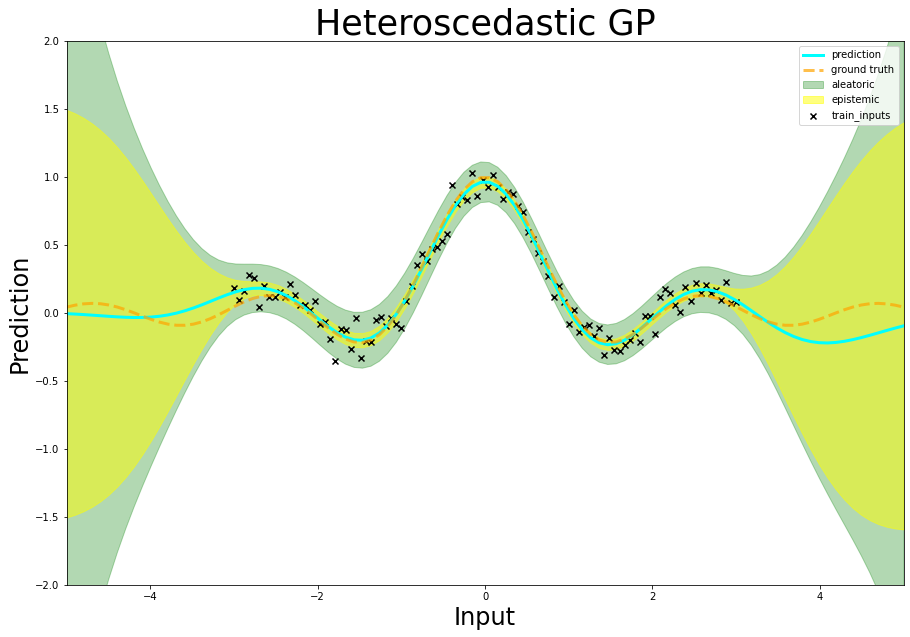

In [ ]:
#heteroscedastic GP inference
mean, epistemic= hetero_gp_mdl.predict_f(test_data.x)
_, aleatoric = hetero_gp_mdl.predict_y(test_data.x)
function_samples = hetero_gp_mdl.predict_f_samples(test_data.x,10)
#plot outputs
plot_results(train_data,test_data, mean, aleatoric, epistemic,limits={"x":(-5,5),"y":(-2,2)},fn_samples=function_samples,title='Heteroscedastic GP')